In [1]:
# Install additional dependencies only (DO NOT uninstall Kaggle defaults)
!pip install -U --quiet \
  opencv-python matplotlib numpy==1.26.4 Pillow==10.4.0 \
  supervision==0.26.1 \
  git+https://github.com/facebookresearch/segment-anything.git

# Optional: verify environment
import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 45.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 102.4 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
ydata-profiling 4.16.1 requires matplotlib<=3.10,>=3.5, but you have matplotlib 3.10.5 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
bigframes 2.8.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.8.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatib

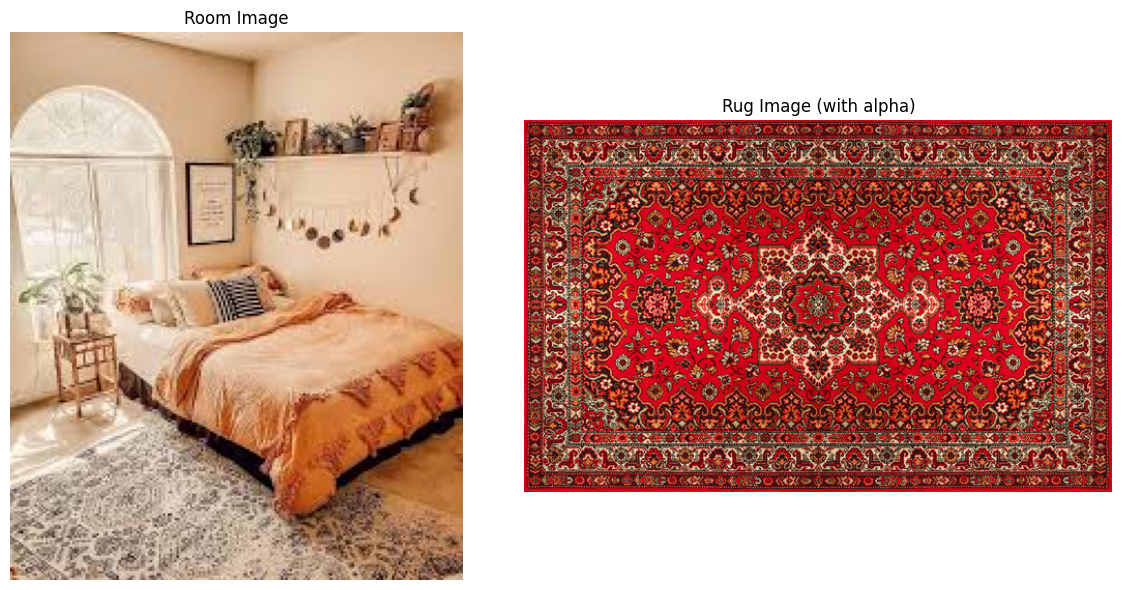

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

# Load images from Kaggle Files tab
room_path = "/kaggle/input/roomjpg/images.jpg"  # update if needed
rug_path = "/kaggle/input/rugimage/rug.jpg"

assert os.path.exists(room_path), "Room image not found!"
assert os.path.exists(rug_path), "Rug image not found!"

# Load and convert
room_img = Image.open(room_path).convert("RGB")
rug_img = Image.open(rug_path).convert("RGBA")  # Keep transparency

# Resize room image if too large
MAX_DIM = 1024
room_w, room_h = room_img.size
if max(room_w, room_h) > MAX_DIM:
    scale = MAX_DIM / max(room_w, room_h)
    room_img = room_img.resize((int(room_w * scale), int(room_h * scale)))
    print(f"🔄 Room image resized to {room_img.size}")

# Convert to NumPy
room_np = np.array(room_img)
rug_np = np.array(rug_img)

# Show
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(room_np)
plt.title("Room Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(rug_np)
plt.title("Rug Image (with alpha)")
plt.axis("off")

plt.tight_layout()
plt.show()


Generating masks with SAM (may take ~20s)...
Total masks found: 130


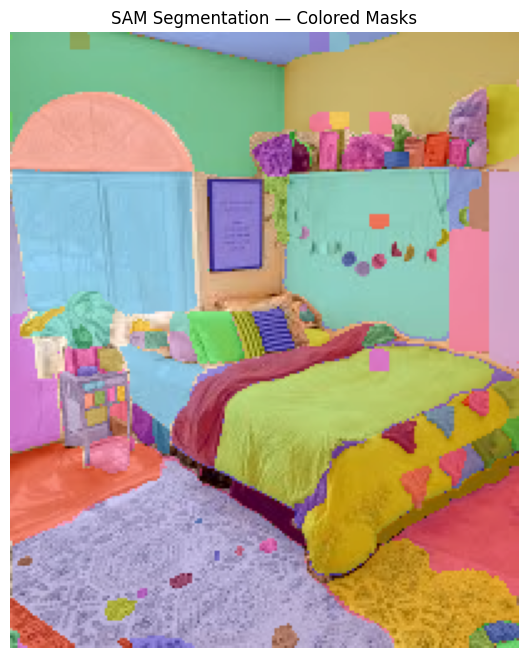

In [19]:
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import supervision as sv
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

# --- Step 1: Download SAM checkpoint ---
sam_ckpt_url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
sam_checkpoint = "sam_vit_h_4b8939.pth"

if not os.path.exists(sam_checkpoint):
    !wget $sam_ckpt_url -O $sam_checkpoint

# --- Step 2: Load SAM model ---
sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint)
device = "cuda" if torch.cuda.is_available() else "cpu"
sam.to(device)

# --- Step 3: Run SAM mask generator ---
print("Generating masks with SAM (may take ~20s)...")
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.92,
    crop_n_layers=1,
)

sam_masks = mask_generator.generate(room_np)
print(f"Total masks found: {len(sam_masks)}")

# --- Step 4: Visualize and save segmented overlay ---
annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
seg_img = annotator.annotate(scene=room_np.copy(), detections=sv.Detections.from_sam(sam_masks))

# Save overlay image for future use
cv2.imwrite("segmented_overlay.png", cv2.cvtColor(seg_img, cv2.COLOR_RGB2BGR))
global_seg_img = seg_img.copy()

# Show overlay
plt.figure(figsize=(12, 8))
plt.imshow(seg_img)
plt.axis("off")
plt.title("SAM Segmentation — Colored Masks")
plt.show()


Showing 5 of 130 masks (area > 5000)


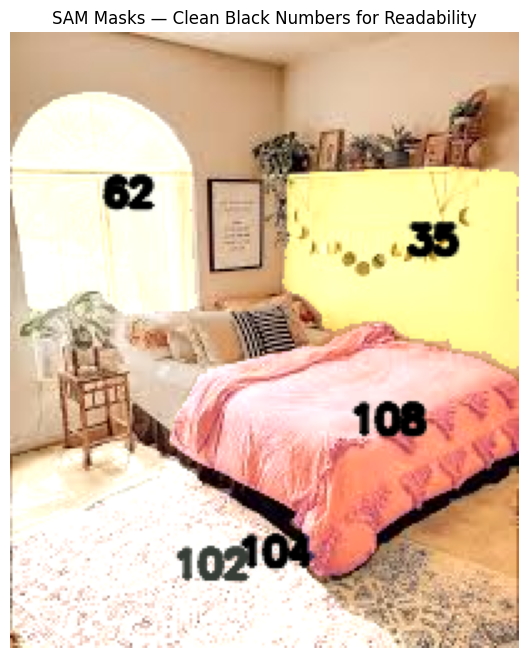

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Filter for large masks only
min_area = 5000
large_mask_ids = [i for i, m in enumerate(sam_masks) if m["area"] > min_area]
print(f"Showing {len(large_mask_ids)} of {len(sam_masks)} masks (area > {min_area})")

# Use original room image as base
overlay = room_np.copy()

# Random mask colors
np.random.seed(42)
colors = [np.random.randint(0, 255, size=3).tolist() for _ in sam_masks]

# Draw each mask and black label
for idx in large_mask_ids:
    m = sam_masks[idx]
    mask = m["segmentation"].astype(np.uint8)

    # Color the mask
    color = colors[idx]
    colored_mask = np.zeros_like(overlay)
    for i in range(3):
        colored_mask[..., i] = mask * color[i]
    overlay = cv2.addWeighted(overlay, 1.0, colored_mask, 0.3, 0)

    # Draw black number at centroid
    ys, xs = np.where(mask)
    if len(xs) > 0 and len(ys) > 0:
        cx = int(xs.mean())
        cy = int(ys.mean())
        text = str(idx)
        cv2.putText(
            overlay, text, (cx, cy),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=0.5, color=(0, 0, 0), thickness=2, lineType=cv2.LINE_AA
        )

# Show result
plt.figure(figsize=(12, 8))
plt.imshow(overlay)
plt.axis("off")
plt.title("SAM Masks — Clean Black Numbers for Readability")
plt.show()


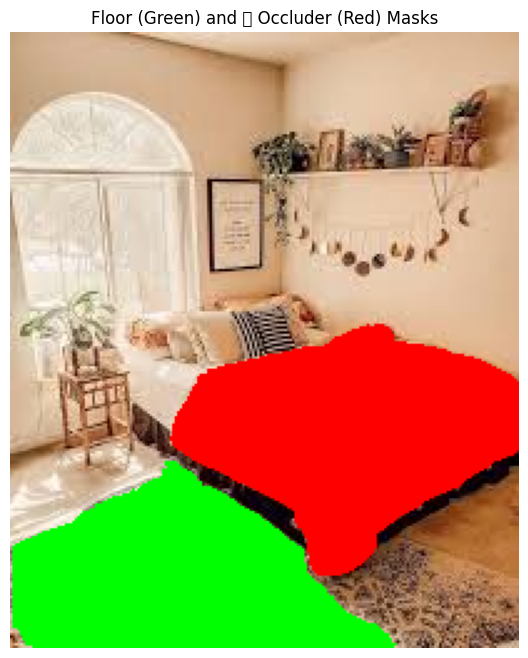

Masks saved: floor_mask.npy, occluder_mask.npy


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# --- Your selected SAM mask IDs ---
floor_mask_ids = [102]
occluder_mask_ids = [108]

# --- Initialize blank binary masks ---
floor_mask = np.zeros(room_np.shape[:2], dtype=np.uint8)
occluder_mask = np.zeros_like(floor_mask)

# --- Fill in masks using selected segments ---
for idx in floor_mask_ids:
    floor_mask |= sam_masks[idx]['segmentation'].astype(np.uint8)

for idx in occluder_mask_ids:
    occluder_mask |= sam_masks[idx]['segmentation'].astype(np.uint8)

# --- Preview overlay of floor and occluder masks ---
preview = room_np.copy()
preview[floor_mask.astype(bool)] = [0, 255, 0]        # Green = Floor
preview[occluder_mask.astype(bool)] = [255, 0, 0]     # Red = Occluder

# --- Show the result ---
plt.figure(figsize=(12, 8))
plt.imshow(preview)
plt.axis("off")
plt.title("Floor (Green) and 🟥 Occluder (Red) Masks")
plt.show()

# --- Save masks for next step ---
np.save("floor_mask.npy", floor_mask)
np.save("occluder_mask.npy", occluder_mask)
print("Masks saved: floor_mask.npy, occluder_mask.npy")


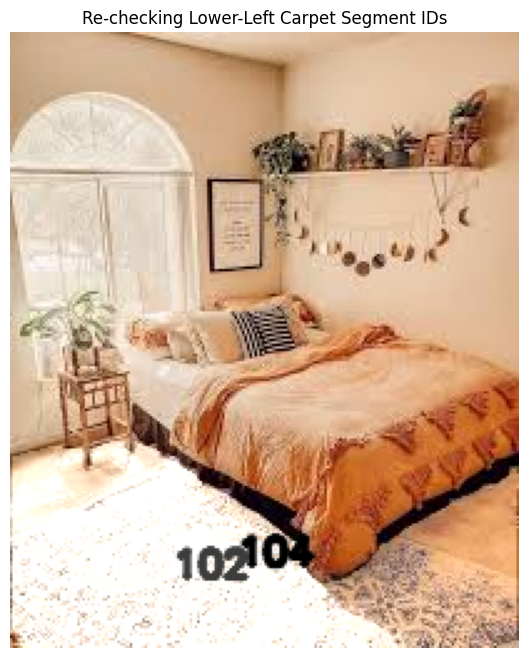

Candidate mask IDs in bottom-left: [102, 104]


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Reload original room image
room_h, room_w = room_np.shape[:2]

# Define a region of interest: bottom-left quadrant
x_thresh = room_w // 2
y_thresh = room_h // 2

# Re-analyze masks in that quadrant and above area threshold
min_area = 3000
target_mask_ids = []

for i, m in enumerate(sam_masks):
    if m["area"] < min_area:
        continue
    ys, xs = np.where(m["segmentation"])
    if len(xs) == 0: continue
    if xs.mean() < x_thresh and ys.mean() > y_thresh:
        target_mask_ids.append(i)

# Create a copy of the image
overlay = room_np.copy()

for idx in target_mask_ids:
    m = sam_masks[idx]
    mask = m["segmentation"].astype(np.uint8)
    colored_mask = np.zeros_like(overlay)
    for c in range(3):
        colored_mask[..., c] = mask * 200  # neutral gray
    overlay = cv2.addWeighted(overlay, 1.0, colored_mask, 0.3, 0)

    ys, xs = np.where(mask)
    if len(xs) > 0 and len(ys) > 0:
        cx = int(xs.mean())
        cy = int(ys.mean())
        cv2.putText(
            overlay, str(idx), (cx, cy),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=0.5, color=(0, 0, 0), thickness=2, lineType=cv2.LINE_AA
        )

plt.figure(figsize=(12, 8))
plt.imshow(overlay)
plt.axis("off")
plt.title("Re-checking Lower-Left Carpet Segment IDs")
plt.show()

print(f"Candidate mask IDs in bottom-left: {target_mask_ids}")


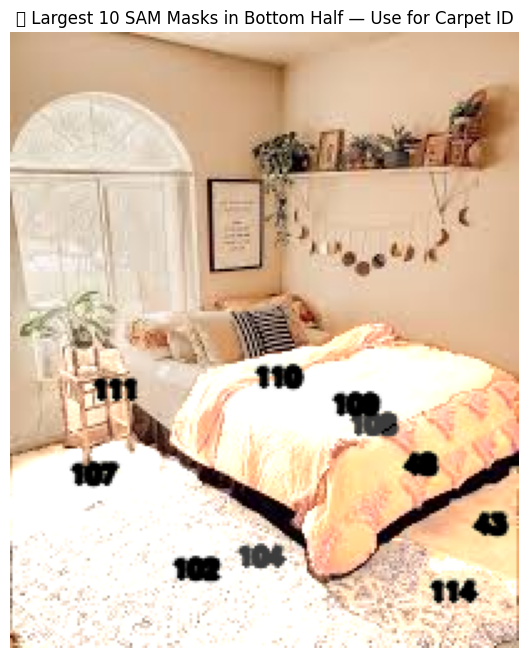

Candidate bottom-half mask IDs (top 10 by area): [104, 108, 102, 109, 48, 114, 107, 43, 110, 111]


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

room_h, room_w = room_np.shape[:2]
mid_y = room_h // 2

# Step 1: Filter masks in bottom half
bottom_half_masks = []
for i, m in enumerate(sam_masks):
    ys, xs = np.where(m["segmentation"])
    if len(xs) == 0: continue
    if np.mean(ys) > mid_y:
        bottom_half_masks.append((i, m["area"]))

# Step 2: Sort by area and take top 10
top_bottom_masks = sorted(bottom_half_masks, key=lambda x: x[1], reverse=True)[:10]
target_mask_ids = [idx for idx, _ in top_bottom_masks]

# Step 3: Draw overlays with numbers
overlay = room_np.copy()
for idx in target_mask_ids:
    mask = sam_masks[idx]["segmentation"].astype(np.uint8)
    color_mask = np.zeros_like(overlay)
    for c in range(3):
        color_mask[..., c] = mask * 200
    overlay = cv2.addWeighted(overlay, 1.0, color_mask, 0.3, 0)

    ys, xs = np.where(mask)
    if len(xs) > 0 and len(ys) > 0:
        cx = int(xs.mean())
        cy = int(ys.mean())
        cv2.putText(
            overlay, str(idx), (cx, cy),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=0.3, color=(0, 0, 0), thickness=2, lineType=cv2.LINE_AA
        )

plt.figure(figsize=(12, 8))
plt.imshow(overlay)
plt.axis("off")
plt.title("📌 Largest 10 SAM Masks in Bottom Half — Use for Carpet ID")
plt.show()

print("Candidate bottom-half mask IDs (top 10 by area):", target_mask_ids)


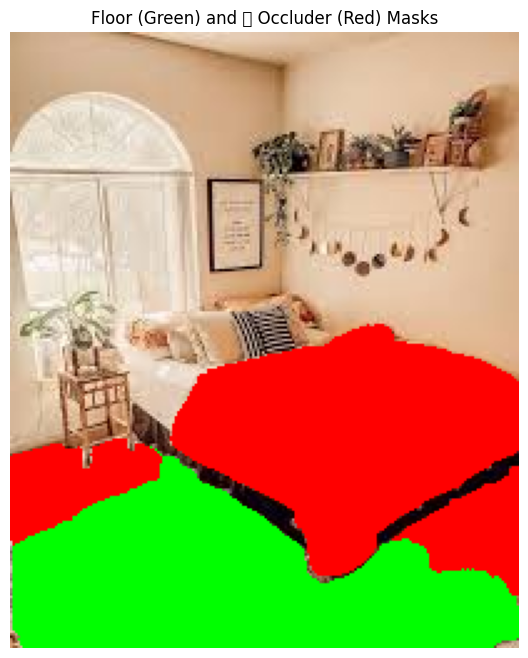

Masks saved: floor_mask.npy, occluder_mask.npy


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# --- Your selected SAM mask IDs ---
floor_mask_ids = [102,114,104]
occluder_mask_ids = [108,107,43]

# --- Initialize blank binary masks ---
floor_mask = np.zeros(room_np.shape[:2], dtype=np.uint8)
occluder_mask = np.zeros_like(floor_mask)

# --- Fill in masks using selected segments ---
for idx in floor_mask_ids:
    floor_mask |= sam_masks[idx]['segmentation'].astype(np.uint8)

for idx in occluder_mask_ids:
    occluder_mask |= sam_masks[idx]['segmentation'].astype(np.uint8)

# --- Preview overlay of floor and occluder masks ---
preview = room_np.copy()
preview[floor_mask.astype(bool)] = [0, 255, 0]        # Green = Floor
preview[occluder_mask.astype(bool)] = [255, 0, 0]     # Red = Occluder

# --- Show the result ---
plt.figure(figsize=(12, 8))
plt.imshow(preview)
plt.axis("off")
plt.title("Floor (Green) and 🟥 Occluder (Red) Masks")
plt.show()

# --- Save masks for next step ---
np.save("floor_mask.npy", floor_mask)
np.save("occluder_mask.npy", occluder_mask)
print("Masks saved: floor_mask.npy, occluder_mask.npy")


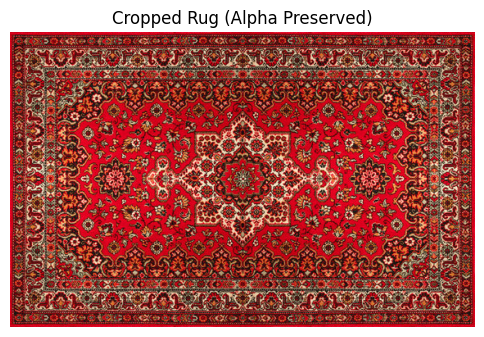

Cropped rug saved as 'cropped_rug.npy'


In [9]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# --- Load rug image (supports alpha if present) ---
rug_path = "/kaggle/input/rugimage/rug.jpg"  # Change if you uploaded a different rug
rug_img = Image.open(rug_path).convert("RGBA")

# --- Convert to numpy array ---
rug_np = np.array(rug_img)

# --- Auto-crop transparent or empty borders ---
alpha_channel = rug_np[:, :, 3]
non_empty_coords = np.argwhere(alpha_channel > 10)

y_min, x_min = non_empty_coords.min(axis=0)
y_max, x_max = non_empty_coords.max(axis=0)

cropped_rug = rug_np[y_min:y_max+1, x_min:x_max+1]

# --- Show cropped rug ---
plt.figure(figsize=(6, 6))
plt.imshow(cropped_rug)
plt.axis("off")
plt.title("Cropped Rug (Alpha Preserved)")
plt.show()

# --- Save for later use ---
np.save("cropped_rug.npy", cropped_rug)
print("Cropped rug saved as 'cropped_rug.npy'")


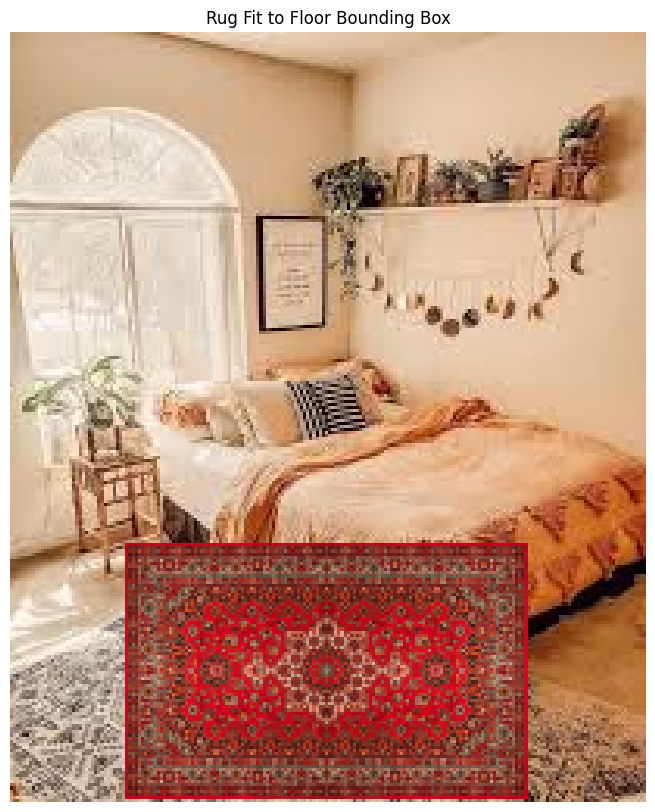

Rug warped and saved as 'warped_rug.npy'


In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Load assets ---
floor_mask = np.load("floor_mask.npy")
rug = np.load("cropped_rug.npy")

# --- Get bounding box of floor mask ---
ys, xs = np.where(floor_mask > 0)
min_y, max_y = ys.min(), ys.max()
min_x, max_x = xs.min(), xs.max()

target_h = max_y - min_y
target_w = max_x - min_x

# --- Resize rug to match floor box (maintain aspect ratio) ---
rug_h, rug_w = rug.shape[:2]
scale = min(target_w / rug_w, target_h / rug_h)
new_size = (int(rug_w * scale), int(rug_h * scale))

rug_resized = cv2.resize(rug, new_size, interpolation=cv2.INTER_AREA)

# --- Create empty transparent canvas ---
warped_rug = np.zeros((*floor_mask.shape, 4), dtype=np.uint8)

# --- Center rug inside bounding box ---
start_y = min_y + (target_h - new_size[1]) // 2
start_x = min_x + (target_w - new_size[0]) // 2

warped_rug[start_y:start_y + new_size[1], start_x:start_x + new_size[0]] = rug_resized

# --- Show preview ---
plt.figure(figsize=(10, 10))
overlay = room_np.copy()
alpha = warped_rug[:, :, 3] > 0
overlay[alpha] = warped_rug[:, :, :3][alpha]

plt.imshow(overlay)
plt.axis("off")
plt.title("Rug Fit to Floor Bounding Box")
plt.show()

# --- Save for next step ---
np.save("warped_rug.npy", warped_rug)
print("Rug warped and saved as 'warped_rug.npy'")


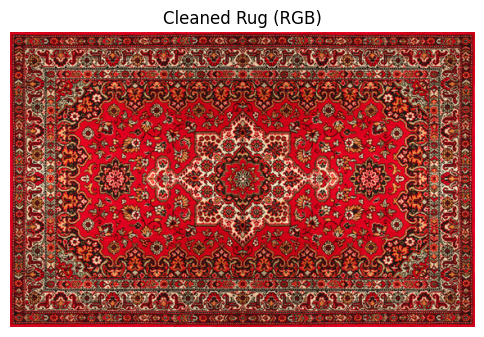

In [11]:
from PIL import Image

# Load rug image with possible alpha channel (e.g., PNG with transparency)
rug_img = Image.open("/kaggle/input/rugimage/rug.jpg").convert("RGBA")
rug_np = np.array(rug_img)

# Remove transparency if present by compositing over white
if rug_np.shape[2] == 4:
    alpha_channel = rug_np[:, :, 3] / 255.0
    rgb_channels = rug_np[:, :, :3]
    white_background = np.ones_like(rgb_channels) * 255
    cleaned_rug = (rgb_channels * alpha_channel[..., None] + white_background * (1 - alpha_channel[..., None])).astype(np.uint8)
else:
    cleaned_rug = rug_np[:, :, :3]  # Already RGB

# Visualize
plt.figure(figsize=(6, 6))
plt.imshow(cleaned_rug)
plt.axis("off")
plt.title("Cleaned Rug (RGB)")
plt.show()


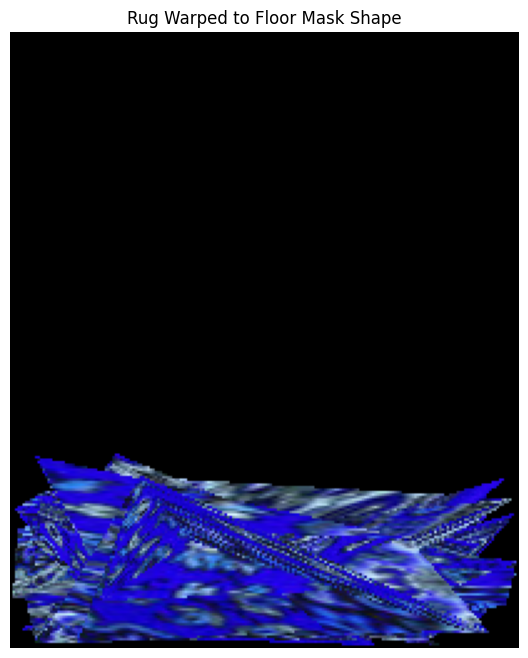

Warped rug saved as 'rug_warped_to_floor.png'


In [12]:
import cv2
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

# Load room image, floor mask, and rug
floor_mask = np.load("floor_mask.npy")
room_img = room_np.copy()
src_rug = cleaned_rug.copy()  # Make sure this was defined earlier

# Get coordinates of the non-zero floor region
floor_coords = np.column_stack(np.where(floor_mask > 0))

# Generate a small grid of source points on the rug
src_h, src_w = src_rug.shape[:2]
grid_y, grid_x = np.linspace(0, src_h, 10), np.linspace(0, src_w, 10)
src_points = np.array([[x, y] for y in grid_y for x in grid_x], dtype=np.float32)

# Sample corresponding destination points from the floor mask
num_points = len(src_points)
np.random.seed(42)
indices = np.random.choice(len(floor_coords), num_points, replace=True)
dst_points = floor_coords[indices][:, [1, 0]].astype(np.float32)  # swap to (x, y)

# Triangulate the source points
tri = Delaunay(src_points)

# Prepare output canvas
warped_rug = np.zeros_like(room_img, dtype=np.uint8)

# Apply affine transform triangle-by-triangle
for tri_indices in tri.simplices:
    src_tri = np.array([src_points[i] for i in tri_indices], dtype=np.float32)
    dst_tri = np.array([dst_points[i] for i in tri_indices], dtype=np.float32)

    # Compute bounding rectangles
    src_rect = cv2.boundingRect(src_tri)
    dst_rect = cv2.boundingRect(dst_tri)

    # Skip degenerate rectangles
    if src_rect[2] < 1 or src_rect[3] < 1 or dst_rect[2] < 1 or dst_rect[3] < 1:
        continue

    # Offset triangles to local rectangle origin
    src_tri_offset = src_tri - np.array(src_rect[:2], dtype=np.float32)
    dst_tri_offset = dst_tri - np.array(dst_rect[:2], dtype=np.float32)

    # Enforce shape and dtype
    try:
        src_tri_offset = np.reshape(src_tri_offset, (3, 2)).astype(np.float32)
        dst_tri_offset = np.reshape(dst_tri_offset, (3, 2)).astype(np.float32)
    except:
        continue

    if src_tri_offset.shape != (3, 2) or dst_tri_offset.shape != (3, 2):
        continue

    # Crop source triangle region
    src_crop = src_rug[
        src_rect[1]:src_rect[1]+src_rect[3],
        src_rect[0]:src_rect[0]+src_rect[2]
    ]

    # Skip if crop is too small
    if src_crop.shape[0] < 1 or src_crop.shape[1] < 1:
        continue

    # Create mask for the triangle
    mask = np.zeros((dst_rect[3], dst_rect[2], 3), dtype=np.uint8)
    cv2.fillConvexPoly(mask, np.int32(dst_tri_offset), (1, 1, 1), 16)

    # Warp triangle
    M = cv2.getAffineTransform(src_tri_offset, dst_tri_offset)
    warped = cv2.warpAffine(src_crop, M, (dst_rect[2], dst_rect[3]),
                            flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

    # Paste warped triangle into final image
    roi = warped_rug[
        dst_rect[1]:dst_rect[1]+dst_rect[3],
        dst_rect[0]:dst_rect[0]+dst_rect[2]
    ]
    np.copyto(roi, warped, where=mask.astype(bool))

# Show result
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(warped_rug, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Rug Warped to Floor Mask Shape")
plt.show()

# Optionally save
cv2.imwrite("rug_warped_to_floor.png", warped_rug)
print("Warped rug saved as 'rug_warped_to_floor.png'")


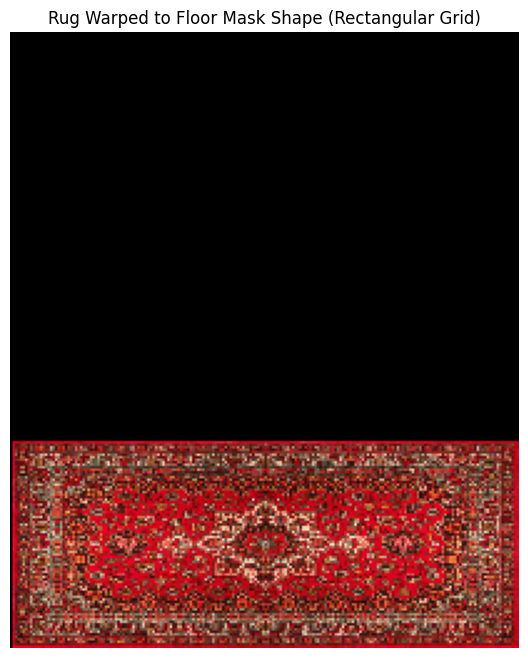

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

# Load room image and rug image from Kaggle datasets
room_img = cv2.imread("/kaggle/input/roomjpg/images.jpg")
room_img = cv2.cvtColor(room_img, cv2.COLOR_BGR2RGB)

cleaned_rug = cv2.imread("/kaggle/input/rugimage/rug.jpg")
cleaned_rug = cv2.cvtColor(cleaned_rug, cv2.COLOR_BGR2RGB)


floor_mask = np.load("floor_mask.npy")

# Get bounding box of floor mask
ys, xs = np.where(floor_mask > 0)
x_min, x_max = xs.min(), xs.max()
y_min, y_max = ys.min(), ys.max()

# Define source grid on rug image
src_h, src_w = cleaned_rug.shape[:2]
num_grid = 20
src_grid_x = np.linspace(0, src_w, num_grid)
src_grid_y = np.linspace(0, src_h, num_grid)
src_points = np.array([[x, y] for y in src_grid_y for x in src_grid_x], dtype=np.float32)

# Define destination grid on floor bounding box
dst_grid_x = np.linspace(x_min, x_max, num_grid)
dst_grid_y = np.linspace(y_min, y_max, num_grid)
dst_points = np.array([[x, y] for y in dst_grid_y for x in dst_grid_x], dtype=np.float32)

# Triangulate source
tri = Delaunay(src_points)

# Prepare blank canvas
warped_rug = np.zeros_like(room_img)

# Warp triangle-by-triangle
for simplex in tri.simplices:
    src_tri = src_points[simplex]
    dst_tri = dst_points[simplex]

    src_rect = cv2.boundingRect(src_tri)
    dst_rect = cv2.boundingRect(dst_tri)

    src_tri_offset = src_tri - src_rect[:2]
    dst_tri_offset = dst_tri - dst_rect[:2]

    src_crop = cleaned_rug[src_rect[1]:src_rect[1]+src_rect[3], src_rect[0]:src_rect[0]+src_rect[2]]
    mask = np.zeros((dst_rect[3], dst_rect[2], 3), dtype=np.uint8)
    cv2.fillConvexPoly(mask, np.int32(dst_tri_offset), (1, 1, 1))

    # Warp triangle
    M = cv2.getAffineTransform(np.float32(src_tri_offset), np.float32(dst_tri_offset))
    warped = cv2.warpAffine(src_crop, M, (dst_rect[2], dst_rect[3]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

    roi = warped_rug[dst_rect[1]:dst_rect[1]+dst_rect[3], dst_rect[0]:dst_rect[0]+dst_rect[2]]
    np.copyto(roi, warped, where=mask.astype(bool))

# Save and show
cv2.imwrite("rug_warped_to_floor.png", cv2.cvtColor(warped_rug, cv2.COLOR_RGB2BGR))

plt.figure(figsize=(10, 8))
plt.imshow(warped_rug)
plt.axis("off")
plt.title("Rug Warped to Floor Mask Shape (Rectangular Grid)")
plt.show()


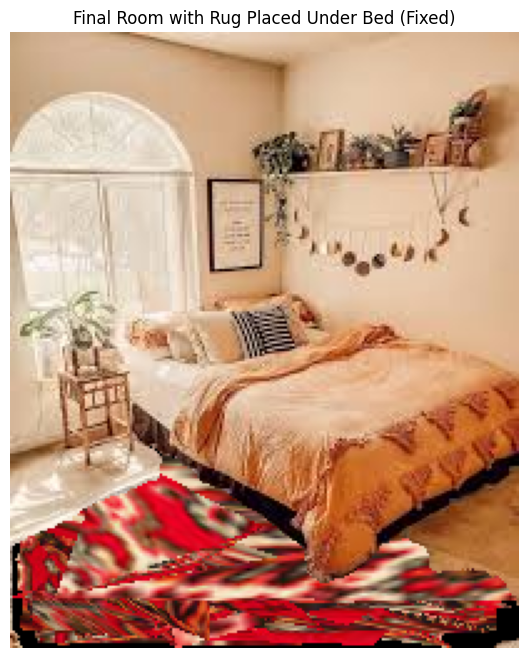

In [14]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import Delaunay

# Load images and masks
room_img = cv2.imread('/kaggle/input/roomjpg/images.jpg')
room_img = cv2.cvtColor(room_img, cv2.COLOR_BGR2RGB)

rug_img = cv2.imread('/kaggle/input/rugimage/rug.jpg')
rug_img = cv2.cvtColor(rug_img, cv2.COLOR_BGR2RGB)

floor_mask = np.load('floor_mask.npy')
occluder_mask = np.load('occluder_mask.npy')

composited_img = room_img.copy()

# Prepare grid-based warping
src_h, src_w = rug_img.shape[:2]
grid_y, grid_x = np.linspace(0, src_h, 15), np.linspace(0, src_w, 15)
src_points = np.array([[x, y] for y in grid_y for x in grid_x], dtype=np.float32)

floor_coords = np.column_stack(np.where(floor_mask > 0))
num_points = len(src_points)
np.random.seed(42)
chosen_indices = np.random.choice(len(floor_coords), num_points, replace=True)
dst_points = floor_coords[chosen_indices][:, [1, 0]].astype(np.float32)

# Triangulate and warp
tri = Delaunay(src_points)
warped_rug = np.zeros_like(room_img)

for tri_indices in tri.simplices:
    src_tri = np.array([src_points[i] for i in tri_indices], dtype=np.float32)
    dst_tri = np.array([dst_points[i] for i in tri_indices], dtype=np.float32)

    if src_tri.shape != (3, 2) or dst_tri.shape != (3, 2):
        continue  # skip bad triangle

    src_rect = cv2.boundingRect(src_tri)
    dst_rect = cv2.boundingRect(dst_tri)

    if src_rect[2] == 0 or src_rect[3] == 0 or dst_rect[2] == 0 or dst_rect[3] == 0:
        continue  # skip degenerate rects

    src_tri_offset = src_tri - src_rect[:2]
    dst_tri_offset = dst_tri - dst_rect[:2]

    src_crop = rug_img[src_rect[1]:src_rect[1]+src_rect[3], src_rect[0]:src_rect[0]+src_rect[2]]
    if src_crop.size == 0:
        continue

    mask = np.zeros((dst_rect[3], dst_rect[2], 3), dtype=np.uint8)
    cv2.fillConvexPoly(mask, np.int32(dst_tri_offset), (1, 1, 1), 16)

    try:
        M = cv2.getAffineTransform(src_tri_offset.astype(np.float32), dst_tri_offset.astype(np.float32))
        warped = cv2.warpAffine(src_crop, M, (dst_rect[2], dst_rect[3]), None,
                                flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
    except cv2.error:
        continue  # skip if warping fails

    roi = warped_rug[dst_rect[1]:dst_rect[1]+dst_rect[3], dst_rect[0]:dst_rect[0]+dst_rect[2]]
    np.copyto(roi, warped, where=mask.astype(bool))

# Final composite
floor_mask_3ch = np.repeat(floor_mask[:, :, np.newaxis], 3, axis=2)
occluder_mask_3ch = np.repeat(occluder_mask[:, :, np.newaxis], 3, axis=2)

composited_img = np.where(floor_mask_3ch == 1, warped_rug, composited_img)
composited_img = np.where(occluder_mask_3ch == 1, room_img, composited_img)

# Save and show
cv2.imwrite("final_rug_applied.png", cv2.cvtColor(composited_img, cv2.COLOR_RGB2BGR))

plt.figure(figsize=(10, 8))
plt.imshow(composited_img)
plt.title("Final Room with Rug Placed Under Bed (Fixed)")
plt.axis("off")
plt.show()


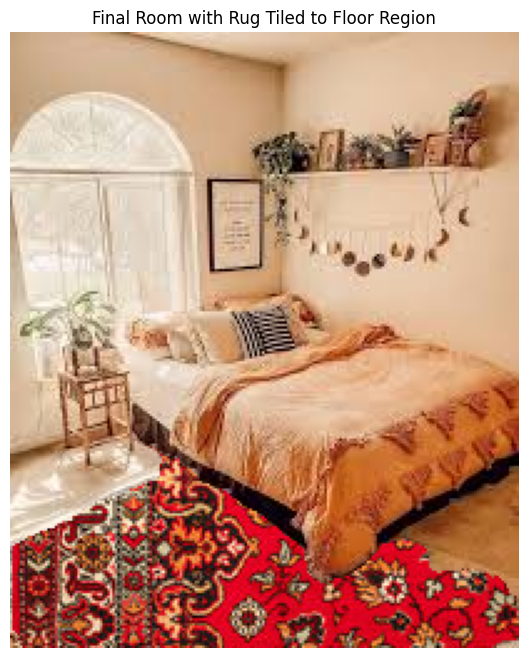

Saved: tiled_rug_on_floor.png


In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Load necessary assets ---
floor_mask = np.load("floor_mask.npy")           # Binary mask for floor
occluder_mask = np.load("occluder_mask.npy")     # Binary mask for occluders (e.g., bed)
room_img = cv2.imread("/kaggle/input/roomjpg/images.jpg")
room_img = cv2.cvtColor(room_img, cv2.COLOR_BGR2RGB)
rug_img = cv2.imread("/kaggle/input/rugimage/rug.jpg")
rug_img = cv2.cvtColor(rug_img, cv2.COLOR_BGR2RGB)

# --- Resize and tile rug to cover the floor mask ---
mask_h, mask_w = floor_mask.shape
rug_h, rug_w = rug_img.shape[:2]

# Compute how many tiles needed
tiles_y = int(np.ceil(mask_h / rug_h))
tiles_x = int(np.ceil(mask_w / rug_w))

# Tile the rug image
tiled_rug = np.tile(rug_img, (tiles_y, tiles_x, 1))[:mask_h, :mask_w]

# --- Create final rug image only inside floor mask ---
floor_mask_3c = np.repeat(floor_mask[:, :, np.newaxis], 3, axis=2)
rug_masked = np.where(floor_mask_3c == 1, tiled_rug, 0)

# --- Apply occluder mask to keep bed/etc. above the rug ---
occluder_mask_3c = np.repeat(occluder_mask[:, :, np.newaxis], 3, axis=2)
final_img = np.where(floor_mask_3c == 1, rug_masked, room_img)  # Paste rug into floor
final_img = np.where(occluder_mask_3c == 1, room_img, final_img)  # Bed stays on top

# --- Display the result ---
plt.figure(figsize=(10, 8))
plt.imshow(final_img)
plt.axis("off")
plt.title("Final Room with Rug Tiled to Floor Region")
plt.show()

# Optionally save
cv2.imwrite("tiled_rug_on_floor.png", cv2.cvtColor(final_img, cv2.COLOR_RGB2BGR))
print("Saved: tiled_rug_on_floor.png")


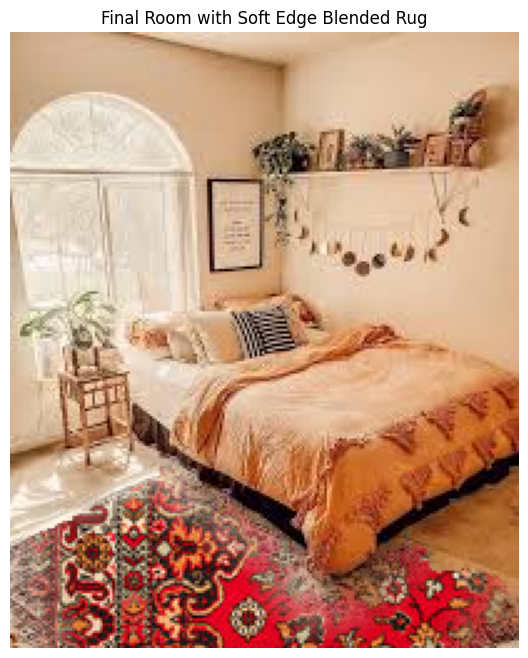

Saved: rug_soft_blend.png


In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load all necessary files
room_img = cv2.imread("/kaggle/input/roomjpg/images.jpg")
room_img = cv2.cvtColor(room_img, cv2.COLOR_BGR2RGB)

rug_on_floor = cv2.imread("tiled_rug_on_floor.png")
rug_on_floor = cv2.cvtColor(rug_on_floor, cv2.COLOR_BGR2RGB)

floor_mask = np.load("floor_mask.npy")  # binary mask (0 or 1), rug region

# ----------------- Create soft edge mask -------------------
# Distance transform for feathering (only on mask border)
from scipy.ndimage import distance_transform_edt

feather_radius = 25  # Increase for softer edges
hard_mask = (floor_mask > 0).astype(np.uint8)

dist_to_zero = distance_transform_edt(hard_mask)
dist_to_one = distance_transform_edt(1 - hard_mask)
blend_band = np.clip(dist_to_zero, 0, feather_radius) / feather_radius
soft_mask = np.clip(blend_band, 0, 1)

# Make 3-channel alpha mask for RGB blending
alpha_mask = np.dstack([soft_mask] * 3)

# ----------------- Blend -------------------
# Smooth blend of rug and original image
blended_output = (rug_on_floor * alpha_mask + room_img * (1 - alpha_mask)).astype(np.uint8)

# ----------------- Show and Save -------------------
plt.figure(figsize=(10, 8))
plt.imshow(blended_output)
plt.axis("off")
plt.title("Final Room with Soft Edge Blended Rug")
plt.show()

cv2.imwrite("rug_soft_blend.png", cv2.cvtColor(blended_output, cv2.COLOR_RGB2BGR))
print("Saved: rug_soft_blend.png")


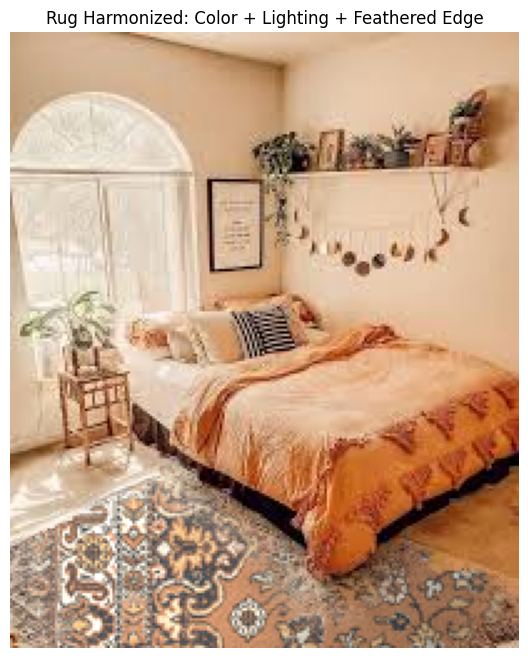

In [17]:
# Lighting & Color Harmonization for the tiled rug (Kaggle-ready)
# - Reads your existing room/rug/masks
# - If "tiled_rug_on_floor.png" doesn't exist, re-tiles the rug
# - Applies color transfer (Reinhard) from room-floor to rug
# - Applies low‑frequency lighting (shading) from room-floor to rug
# - Feather-blends edges and re-applies occluders
# Produces: rug_harmonized.png

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt

# ---------- Inputs ----------
room_path = "/kaggle/input/roomjpg/images.jpg"
rug_path  = "/kaggle/input/rugimage/rug.jpg"
floor_mask = np.load("floor_mask.npy").astype(np.uint8)       # 0/1
occluder_mask = np.load("occluder_mask.npy").astype(np.uint8) # 0/1

# ---------- Load base images ----------
room_img = cv2.cvtColor(cv2.imread(room_path), cv2.COLOR_BGR2RGB)
rug_src  = cv2.cvtColor(cv2.imread(rug_path),  cv2.COLOR_BGR2RGB)

H, W = room_img.shape[:2]
floor_mask = cv2.resize(floor_mask, (W, H), interpolation=cv2.INTER_NEAREST)
occluder_mask = cv2.resize(occluder_mask, (W, H), interpolation=cv2.INTER_NEAREST)

# ---------- Ensure we have a tiled rug already; if not, create it quickly ----------
if os.path.exists("tiled_rug_on_floor.png"):
    base_rug_on_floor = cv2.cvtColor(cv2.imread("tiled_rug_on_floor.png"), cv2.COLOR_BGR2RGB)
else:
    # Quick tiling to fill the canvas, then apply only inside floor mask
    rh, rw = rug_src.shape[:2]
    tiles_y = int(np.ceil(H / rh))
    tiles_x = int(np.ceil(W / rw))
    tiled = np.tile(rug_src, (tiles_y, tiles_x, 1))[:H, :W]
    fm3 = np.repeat(floor_mask[:, :, None], 3, axis=2)
    base_rug_on_floor = np.where(fm3 == 1, tiled, room_img)
    # Keep occluders above
    om3 = np.repeat(occluder_mask[:, :, None], 3, axis=2)
    base_rug_on_floor = np.where(om3 == 1, room_img, base_rug_on_floor)
    cv2.imwrite("tiled_rug_on_floor.png", cv2.cvtColor(base_rug_on_floor, cv2.COLOR_RGB2BGR))

# ---------- Extract rug-only layer (inside floor) ----------
fm3 = np.repeat(floor_mask[:, :, None], 3, axis=2)
rug_layer = np.where(fm3 == 1, base_rug_on_floor, 0)

# ---------- Reinhard Color Transfer (room-floor -> rug) ----------
def reinhard_color_transfer(src_rgb, tgt_rgb, mask_binary):
    # src_rgb: room image; tgt_rgb: rug image; mask_binary: floor region (0/1)
    # compute stats in LAB
    src_lab = cv2.cvtColor(src_rgb, cv2.COLOR_RGB2LAB).astype(np.float32)
    tgt_lab = cv2.cvtColor(tgt_rgb, cv2.COLOR_RGB2LAB).astype(np.float32)

    m = mask_binary.astype(bool)
    # avoid zero-size mask
    if np.count_nonzero(m) < 50:
        return tgt_rgb.copy()

    src_stats = []
    tgt_stats = []
    for c in range(3):
        s = src_lab[..., c][m]
        t = tgt_lab[..., c][m]
        src_stats.append((np.mean(s), np.std(s) + 1e-6))
        tgt_stats.append((np.mean(t), np.std(t) + 1e-6))

    out_lab = tgt_lab.copy()
    for c in range(3):
        mu_s, sd_s = src_stats[c]
        mu_t, sd_t = tgt_stats[c]
        out_lab[..., c][m] = ((tgt_lab[..., c][m] - mu_t) / sd_t) * sd_s + mu_s

    out_lab = np.clip(out_lab, 0, 255).astype(np.uint8)
    return cv2.cvtColor(out_lab, cv2.COLOR_LAB2RGB)

# Prepare sources for stats: room-floor pixels vs rug-floor pixels
room_floor_only = np.where(fm3 == 1, room_img, 0)
rug_floor_only  = np.where(fm3 == 1, rug_layer, 0)

color_matched_rug = reinhard_color_transfer(room_floor_only, rug_floor_only, floor_mask)

# ---------- Low-frequency lighting (shading) from room applied to rug ----------
room_gray = cv2.cvtColor(room_img, cv2.COLOR_RGB2GRAY).astype(np.float32)
# Strong blur to get illumination field (Gaussian with big kernel / sigma)
illum = cv2.GaussianBlur(room_gray, (0, 0), sigmaX=35, sigmaY=35)
illum = illum / (np.mean(illum[floor_mask == 1]) + 1e-6)  # normalize mean=1 in floor region
illum_3 = np.repeat(illum[:, :, None], 3, axis=2)

shaded_rug = color_matched_rug.astype(np.float32) * illum_3
shaded_rug = np.clip(shaded_rug, 0, 255).astype(np.uint8)

# ---------- Feathered edge alpha for blending ----------
feather_radius = 22
dist_in = distance_transform_edt(floor_mask)  # distance to edge inside rug
soft_alpha = np.clip(dist_in / feather_radius, 0, 1)
soft_alpha = np.minimum(soft_alpha, 1.0)
alpha3 = np.repeat(soft_alpha[:, :, None], 3, axis=2)

# ---------- Composite: start from room, blend shaded+matched rug inside floor, keep occluders on top ----------
composite = (shaded_rug * alpha3 + room_img * (1 - alpha3)).astype(np.uint8)
# Re-apply occluders so bed is above
om3 = np.repeat(occluder_mask[:, :, None], 3, axis=2)
composite = np.where(om3 == 1, room_img, composite)

# ---------- Save & show ----------
cv2.imwrite("rug_harmonized.png", cv2.cvtColor(composite, cv2.COLOR_RGB2BGR))

plt.figure(figsize=(10, 8))
plt.imshow(composite)
plt.axis("off")
plt.title("Rug Harmonized: Color + Lighting + Feathered Edge")
plt.show()


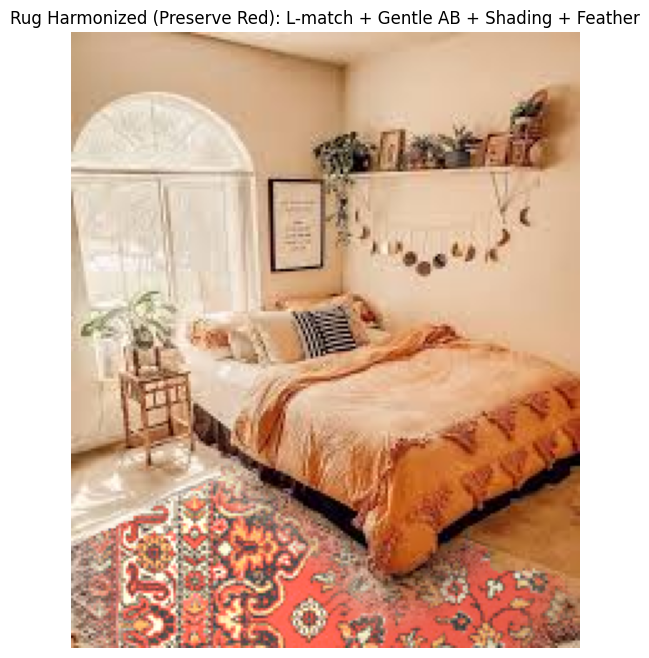

In [18]:
# Harmonize lighting while PRESERVING the rug's red identity
# - Matches only the L (lightness) channel to the room
# - Optional mild a/b (color) blend with adjustable strength
# - Applies soft shading from room illumination with adjustable strength
# - Feathered edges + occluders reapplied
# Produces: rug_harmonized_preserve_red.png

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt

# ---------- Inputs ----------
room_path = "/kaggle/input/roomjpg/images.jpg"
rug_path  = "/kaggle/input/rugimage/rug.jpg"
floor_mask = np.load("floor_mask.npy").astype(np.uint8)       # 0/1
occluder_mask = np.load("occluder_mask.npy").astype(np.uint8) # 0/1

# ---------- Parameters (tune these) ----------
feather_radius  = 22    # edge softness in px
shade_strength  = 0.40  # 0=no shading, 1=full low-freq lighting transfer
ab_strength     = 0.10  # 0=keep original rug color fully, 1=full color transfer of a/b (keep small to preserve red!)

# ---------- Load base images ----------
room_img = cv2.cvtColor(cv2.imread(room_path), cv2.COLOR_BGR2RGB)
rug_src  = cv2.cvtColor(cv2.imread(rug_path),  cv2.COLOR_BGR2RGB)

H, W = room_img.shape[:2]
floor_mask     = cv2.resize(floor_mask,     (W, H), interpolation=cv2.INTER_NEAREST)
occluder_mask  = cv2.resize(occluder_mask,  (W, H), interpolation=cv2.INTER_NEAREST)
fm3 = np.repeat(floor_mask[:, :, None], 3, axis=2)
om3 = np.repeat(occluder_mask[:, :, None], 3, axis=2)

# ---------- Ensure we have a tiled rug covering the canvas (no distortion) ----------
rh, rw = rug_src.shape[:2]
tiles_y = int(np.ceil(H / rh))
tiles_x = int(np.ceil(W / rw))
tiled = np.tile(rug_src, (tiles_y, tiles_x, 1))[:H, :W]
rug_floor_only = np.where(fm3 == 1, tiled, 0)   # rug only inside floor

# ---------- Color harmonization: L-channel match (preserve a/b -> red) ----------
room_lab = cv2.cvtColor(room_img, cv2.COLOR_RGB2LAB).astype(np.float32)
rug_lab  = cv2.cvtColor(rug_floor_only, cv2.COLOR_RGB2LAB).astype(np.float32)

m = floor_mask.astype(bool)
if np.count_nonzero(m) > 50:
    # L channel statistics on floor
    room_L = room_lab[..., 0][m]
    rug_L  = rug_lab[..., 0][m]
    mu_r, sd_r = float(room_L.mean()), float(room_L.std() + 1e-6)
    mu_u, sd_u = float(rug_L.mean()),  float(rug_L.std()  + 1e-6)

    # Replace / blend only the L channel
    L_new = rug_lab[..., 0].copy()
    L_adj = (rug_lab[..., 0] - mu_u) / sd_u * sd_r + mu_r
    # full L replace inside floor, keep outside as is
    L_new[m] = L_adj[m]
    rug_lab[..., 0] = np.clip(L_new, 0, 255)

    # Very mild a/b blending (to gently warm/cool WITHOUT killing red)
    if ab_strength > 0:
        for c in (1, 2):  # a, b
            r_mu, r_sd = float(room_lab[..., c][m].mean()), float(room_lab[..., c][m].std() + 1e-6)
            u_mu, u_sd = float(rug_lab[..., c][m].mean()),  float(rug_lab[..., c][m].std()  + 1e-6)
            target = (rug_lab[..., c] - u_mu) / u_sd * r_sd + r_mu
            blended = (1 - ab_strength) * rug_lab[..., c] + ab_strength * target
            rug_lab[..., c][m] = blended[m]

rug_color_matched = cv2.cvtColor(np.clip(rug_lab, 0, 255).astype(np.uint8), cv2.COLOR_LAB2RGB)

# Keep rug only in floor region
rug_color_matched = np.where(fm3 == 1, rug_color_matched, 0)

# ---------- Low-frequency shading from room (multiplicative; gentle) ----------
room_gray = cv2.cvtColor(room_img, cv2.COLOR_RGB2GRAY).astype(np.float32)
illum = cv2.GaussianBlur(room_gray, (0, 0), sigmaX=35, sigmaY=35)
mean_floor = float(illum[m].mean() + 1e-6)
illum_norm = (illum / mean_floor) ** shade_strength   # exponent to temper effect
illum_3 = np.repeat(illum_norm[:, :, None], 3, axis=2)

rug_shaded = np.clip(rug_color_matched.astype(np.float32) * illum_3, 0, 255).astype(np.uint8)

# ---------- Feathered alpha on floor edges ----------
dist_in = distance_transform_edt(floor_mask)  # distance to edge inside rug
alpha_soft = np.clip(dist_in / feather_radius, 0, 1)
alpha3 = np.repeat(alpha_soft[:, :, None], 3, axis=2)

# ---------- Composite: blend rug with room using soft alpha; then reapply occluders ----------
composite = (rug_shaded * alpha3 + room_img * (1 - alpha3)).astype(np.uint8)
composite = np.where(om3 == 1, room_img, composite)

# ---------- Save & show ----------
cv2.imwrite("rug_harmonized_preserve_red.png", cv2.cvtColor(composite, cv2.COLOR_RGB2BGR))
plt.figure(figsize=(10, 8))
plt.imshow(composite)
plt.axis("off")
plt.title("Rug Harmonized (Preserve Red): L-match + Gentle AB + Shading + Feather")
plt.show()
